In [17]:
import re
import nltk
nltk.download('stopwords')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from nltk.corpus import stopwords
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /home/dungpm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dungpm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
movie_data = load_files(r"/home/dungpm/dungpm/NLP_author_classification/data")
X, y = movie_data.data, movie_data.target

In [19]:
documents = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    # remove "\n"
    document = re.sub(r'\n\s+', ' ', document)
    # remove "\n"
    document = re.sub(r'\r\s+', ' ', document)
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
    # remove all single "n" characters
    document = re.sub(r'n\s+', ' ', document)
    # remove all single "r" characters
    document = re.sub(r'r\s+', ' ', document)
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    documents.append(document)

In [20]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [21]:
vectorizer = CountVectorizer(max_features=MAX_NB_WORDS, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [22]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = to_categorical(y, 12)

print('Shape of data tensor:', X.shape)
print('Shape of test tensor:', Y.shape)

Shape of data tensor: (106, 250)
Shape of test tensor: (106, 12)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(84, 250) (84, 12)
(22, 250) (22, 12)


In [24]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 5,081,612
Trainable params: 5,081,612
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', 
                                                                  patience=3, min_delta=0.0001)])

Epoch 1/5
2/2 [==============================] - 1s 533ms/step - loss: 2.4637 - accuracy: 0.1045 - val_loss: 2.5135 - val_accuracy: 0.0588
Epoch 2/5
2/2 [==============================] - 1s 467ms/step - loss: 2.4625 - accuracy: 0.1045 - val_loss: 2.5192 - val_accuracy: 0.0588
Epoch 3/5
2/2 [==============================] - 1s 467ms/step - loss: 2.4581 - accuracy: 0.1045 - val_loss: 2.5267 - val_accuracy: 0.0588
Epoch 4/5
2/2 [==============================] - 1s 465ms/step - loss: 2.4586 - accuracy: 0.1045 - val_loss: 2.5333 - val_accuracy: 0.0588


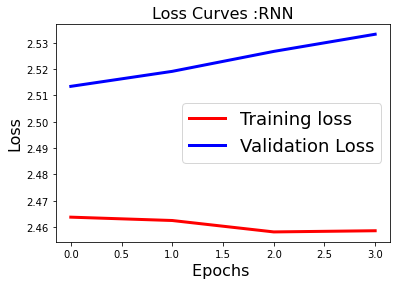

In [27]:
import matplotlib.pyplot as plt
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')

plt.show()

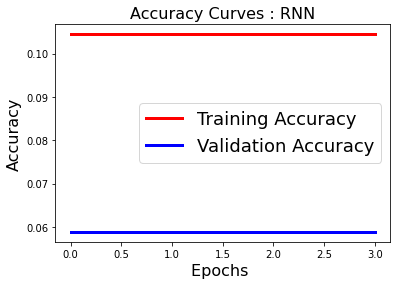

In [28]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [271]:
# Score model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.5134174823760986
Test accuracy: 0.04545454680919647
